<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

## Part 2: Data Science Tools for Medical Deep Learning

The code in this section is based on the <a href="https://courses.nvidia.com/courses/course-v1:DLI+L-HX-07+V1/about">Medical Image Classification with MedNIST</a>. You can find more thorough descriptions of the code and the training of a neural network in that course.

Here, however, we are focused on validating our augmented dataset. The original MedNIST dataset has about 10,000 of each image category; the subset that we augmented had less than 1,000 in some categories. We know that the neural network below, when trained, is able to produce 99.3-99.6% accuracy on MedNIST. Therefore, <b>if our augmentation techniques are robust, we should be able to see a comparable accuracy when trained on the augmented set.</b>

If all we could do with augmentation was reproduce the accuracy of some original set, what would be the point? However, suppose we had a small dataset that was similar in type to MedNIST. Because we validated the accuracy of our augmentation process on MedNIST, we could apply the same techniques to these similar images and have good confidence that the augmented set would be robust. Thus, the general workflow for this type of validation is to develop an augmentation process on a large dataset, then move to a smaller dataset with similar structure, and use it there to generate new data where no additional "ground truth" values are available.


## Quick Overview of Deep Learning

A generic deep neural network consists of a series of <em>layers</em>, running between the input and output layers. Each layer is comprised of <em>nodes</em>, which store intermediate numerical values. The values from each layer are fed to the next after linear transformation by a tensor of <em>weights</em> and a nonlinear <em>activation function</em>. This overall structure is called the <em>architecture</em>.

The X values are mapped through the network to outputs (Y predictions). The Y predictions are compared to the actual Y values, and the difference between them is quantified through a <em>loss function</em>. An <em>optimizer</em> varies the weights of the network over several iterations through the dataset, or <em>epochs</em>, in order to minimize the loss. This process is called <em>training</em> the network.

By providing a large and detailed training dataset, creating an adequately complex network architecture, and training for a sufficient amount of time, the model should be able to predict the correct label for inputs that it has never seen before. Feeding new input into a trained model and making use of its predictions is known as <em>deployment</em>.

In the code below, we load the PyTorch framework and other useful libraries. Due to the mathematically intensive nature of training, the code runs much faster on a GPU than on a conventional CPU, so we set parameters allowing for GPU acceleration. IF the code runs without output, it implies that the libraries were correctly loaded.

### Code Block 1


In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)



## Loading Data for Validation

This code block should be familiar fromt the first notebook. It examines our image set, organizes the filenames, and displays some statistics about them.

### Code Block 2

In [2]:
dataDir = 'imagedata'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)


There are 90000 images in 6 distinct categories
Label names: ['ChestCT', 'CXR', 'AbdomenCT', 'Hand', 'HeadCT', 'BreastMRI']
Label counts: [15000, 15000, 15000, 15000, 15000, 15000]
Image dimensions: 64 x 64


## Transforming Data and Partitioning into Training, Validation, and Testing Sets

We subtract the mean pixel value of each individual image from the rest. The network could in principle learn to do this through training. However, the activation functions tend to be most sensitive / nonlinear near zero. Therefore, shifting our data to have an average input value of zero will improve the sensitivity and stability of initial training steps and tends to speed things up a little. While it doesn't matter much for the simple model we use here, such tricks can make a noticeable difference in complex models.

Also, before doing any of these, we'll need to convert the JPEG images into tensors. We define a function below that combines all these steps.

### Code Block 3

In [3]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z


With the image-to-tensor transformation function defined, we now create a master tensor out of all these images. We also create a tensor for the labels. Execution of this code takes a moment. We double check the final range of scaled pixel values and verify that the mean is (practically) zero.

### Code Block 4

In [4]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))


Rescaled min pixel value = -0.774; Max = 0.971; Mean = -7.49e-10


With everything in order so far, we move on to partitioning these master tensors into three datatsets. In order to prevent overfitting, we partition the data into training, validation, and testing sets.

Because the more data the model sees, the more accurate it tends to become, we usually reserve relatively small fractions for validation and testing.

The code below will randomly assign approximately 10% of the indices to lists corresponding to the validation and testing sets. Once this is done, we can create these datasets by slicing the master image and label tensors using these lists.

### Code Block 5

In [5]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)



Training images = 71971 Validation = 9129 Testing = 8900


If we're satisfied with the breakdown into training, validation, and testing, we can now use these lists to slice the master tensors with the code below. If not, we can rerun the cell above with different fractions set aside.

### Code Block 6

In [6]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]


## Model Architecture

Our test architecture consists of 2 hidden convolutional layers, 2 hidden fully connected layers, and the output layer. We use ELU as the nonlinear activation function. Again, interested students can study these details in the MedNIST class.

### Code Block 7

In [7]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

With the architecture defined, we create an instance of the model. This single line is separated out so that we can continue or repeat the training code below without resetting the model from scratch, if needed.

### Code Block 8

In [13]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

## Training the Model

Now, it's time to train the model. The next code block does so.

First, we define the hyperparameters of the training. The learning rate reflects how much the model is updated per batch. If it is too small, the training proceeds slowly. If it's too large, the weights will be adjusted too much and miss the true minimum loss, or even become unstable. An epoch is a full run through the training data. Some models require thousands of epochs to train; this one will produce high accuracy with just a handful.

The memory overhead required to feed large datasets through the model can be prohibitive. <em>Batches</em> are an important workaround for this problem. By loading smaller data subsets onto the GPU and training off of them, we can not only save memory, but also speed up the training by making more adjustments to the model per epoch. Smaller batches generally require smaller learning rates to avoid instability, however, so there is some tradeoff.

We define a training loop and shuffle the data into batches. As these are iterated through, the loss is computed for our model. Backpropagation is used to adjust the weights of the network.

After all the training batches are complete, the same process happens for the validation data, without the backpropagation and optimization steps. The average loss is calculated, and we compare the validation loss relative to the training loss to test for overfitting.

Run the cell to train the model.

### Code Block 9

In [14]:
learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer


for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Performed by Darshan Patel")
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break
    

Performed by Darshan Patel
Epoch =   0; Training loss = 0.9467; Validation loss = 0.3699
Performed by Darshan Patel
Epoch =   1; Training loss = 0.2879; Validation loss = 0.1981
Performed by Darshan Patel
Epoch =   2; Training loss = 0.1780; Validation loss = 0.1506
Performed by Darshan Patel
Epoch =   3; Training loss = 0.1398; Validation loss = 0.1269
Performed by Darshan Patel
Epoch =   4; Training loss = 0.1500; Validation loss = 0.1077
Performed by Darshan Patel
Epoch =   5; Training loss = 0.0979; Validation loss = 0.0969
Performed by Darshan Patel
Epoch =   6; Training loss = 0.0841; Validation loss = 0.0822
Performed by Darshan Patel
Epoch =   7; Training loss = 0.0722; Validation loss = 0.0745
Performed by Darshan Patel
Epoch =   8; Training loss = 0.0640; Validation loss = 0.0645
Performed by Darshan Patel
Epoch =   9; Training loss = 0.0568; Validation loss = 0.0615
Performed by Darshan Patel
Epoch =  10; Training loss = 0.1041; Validation loss = 0.3864
Performed by Darshan 

It is most likely that training was halted early to prevent overfitting.

You may have also noticed that the training loss is quite a bit larger than the validation loss for the first several training steps. <b>Based on what you've learned about the training process, can you explain why this happens?</b>

## Testing the Model

With the model fully trained, it's time to apply it to generate predictions from the test dataset. The model outputs a 6 element vector for each image. The individual values of this vector can be thought of, roughly, as relative probabilities that the image belongs in each class. Thus, we consider the class with the maximum value to be the prediction of the model.

We'll use these predictions to generate a confusion matrix. Despite its name, the confusion matrix is easily understood. The rows in the matrix represent the correct classifications, while the columns represent the predictions of the model. When the row and the column agree (i.e., along the diagonal), the model predicted correctly.

The short code snippet below iterates through the test batches and fills the confusion matrix.

### Code Block 10

In [15]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest," = ",correct/nTest,". Original set = 0.994")
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  8759 of 8900  =  0.9841573033707866 . Original set = 0.994
Confusion Matrix:
[[1444    0   31    0    4    2]
 [   0 1431    0   14    0    0]
 [  14    0 1483    2   11    3]
 [   0    9    0 1504    6    2]
 [   5    0   11   13 1438    0]
 [   3    0    1    3    7 1459]]
['ChestCT', 'CXR', 'AbdomenCT', 'Hand', 'HeadCT', 'BreastMRI']


## Validation

This brings us to one way to validate our method of data augmentation. We have a standard to compare to: the un-augmented MedNIST dataset is classified with roughly 99.5% accuracy by this architecture. If our data set approaches this standard, it suggests that the augmentation didn't damage the images in some way. Futhermore, we might then be able to apply these same augmentation techniques to similar image sets where a large standardized set is unavailable. How did your model's accuracy compare to that of the model trained on the original dataset?

Also, we can look at the confusion matrix. Notice that some mistakes are more common than others - <b>does this type of confusion make sense to you?</b>

Let's take a look at some of the images that confused the model. This cell can be rerun to produce more examples.

### Code Block 11

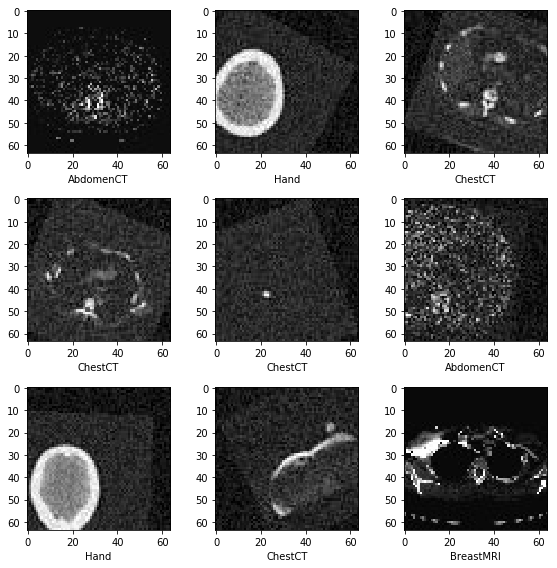

In [16]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()
    
    

Some of these images are indeed confusing, even for a human observer. Yet other other ones are harder to fathom. The field of <a href="https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98">interpretability is beginning to explore these questions</a>.

### Exercise:

Adjust the model parameters and the hyperparameters and run through the code again. Can you improve on the accuracy of the original model? If the new model performs about as well as the original MedNIST classifier (~99.5%), then it suggests success at our data augmentation process.
